In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import save
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from data_loaders import get_tracking_and_plays, create_feature_tensor

# Fetching the Dataset

### Upload kaggle.json

### Download BDB Dataset

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/daniel/.kaggle’: File exists


In [3]:
!kaggle competitions download -c nfl-big-data-bowl-2024

nfl-big-data-bowl-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
replace games.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Data Preprocessing

### Visualization Helpers

In [2]:
def draw_histogram(tensor, num_bins=10):
    """
    Plots a histogram of the values in a 1D PyTorch tensor.

    Parameters:
    tensor (torch.Tensor): A 1D tensor containing the values to be plotted.
    num_bins (int): The number of bins to use for the histogram.
    """

    hist = torch.histc(tensor, bins=num_bins, min=float(tensor.min()), max=float(tensor.max()))
    bin_edges = torch.linspace(start=float(tensor.min()), end=float(tensor.max()), steps=num_bins+1)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], align='edge')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Tensor Values')
    plt.show()

### Create and Save Train and Test Sets
Note that this block of code may take up to 12 hours to complete on a standard consumer grade computer

In [3]:
def create_multiple_tensors(files):
    all_input_tensors = []
    all_target_tensors = []
    i = 1
    for c in files:
        print('Working on file ' + c)
        tracking_with_play_train = get_tracking_and_plays(c)
        input_tensor, target_tensor, reference_tensor, positional_reference_tensor = create_feature_tensor(tracking_with_play_train)
        all_input_tensors.append(input_tensor)
        all_target_tensors.append(target_tensor)
        np.save(f'week_{i}_x_atn.npy', input_tensor)
        np.save(f'week_{i}_y_atn.npy', target_tensor)
        np.save(f'week_{i}_r_atn.npy', reference_tensor)
        np.save(f'week_{i}_pos_r_atn.npy', positional_reference_tensor)
        i+=1
create_multiple_tensors(['tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv','tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv'])

Working on file tracking_week_1.csv


/home/daniel/development/BigDataBowl2024/data_loaders.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/home/daniel/development/BigDataBowl2024/data_loaders.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']
  0%|          | 0/16 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
### Load training and test sets

In [4]:
train_x_arrays = []
train_y_arrays = []
for i in range(1,8):
    print(i)
    curx = np.load(f'week_{i}_x_atn.npy')
    cury = np.load(f'week_{i}_y_atn.npy')
    train_x_arrays.append(curx)
    train_y_arrays.append(cury)


train_x_tensor = np.concatenate(train_x_arrays)
train_y_tensor = np.concatenate(train_y_arrays)

1
2
3
4
5
6
7


In [5]:
test_x_arrays = []
test_y_arrays = []
for i in range(8,10):
    print(i)
    curx = np.load(f'week_{i}_x_atn.npy')
    cury = np.load(f'week_{i}_y_atn.npy')
    test_x_arrays.append(curx)
    test_y_arrays.append(cury)


test_x_tensor = np.concatenate(test_x_arrays)
test_y_tensor = np.concatenate(test_y_arrays)

8
9


In [6]:
train_x = torch.tensor(train_x_tensor, dtype=torch.float)
train_y = torch.tensor(train_y_tensor, dtype=torch.float)

test_x = torch.tensor(test_x_tensor, dtype=torch.float)
test_y = torch.tensor(test_y_tensor, dtype=torch.float)

std_train = train_x.std()
mean_train = train_x.mean()

train_x = (train_x - mean_train) / std_train
test_x = (test_x - mean_train) / std_train

In [7]:
print(std_train)
print(mean_train)

tensor(6.8475)
tensor(-0.2011)


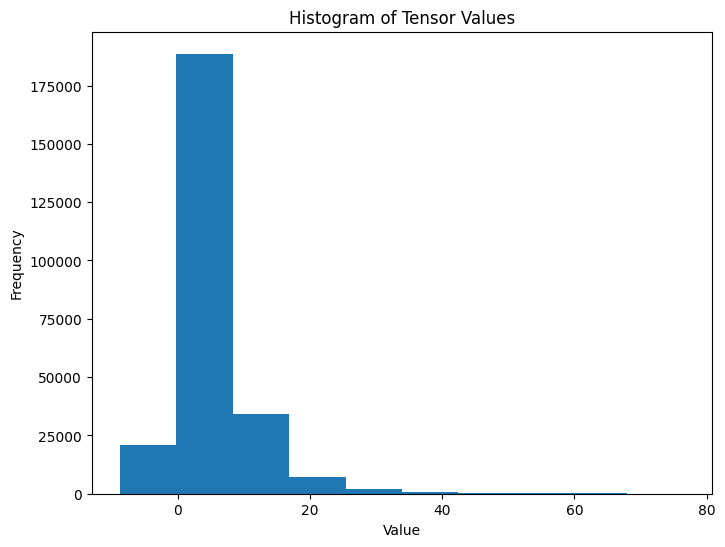

In [8]:
draw_histogram(train_y)

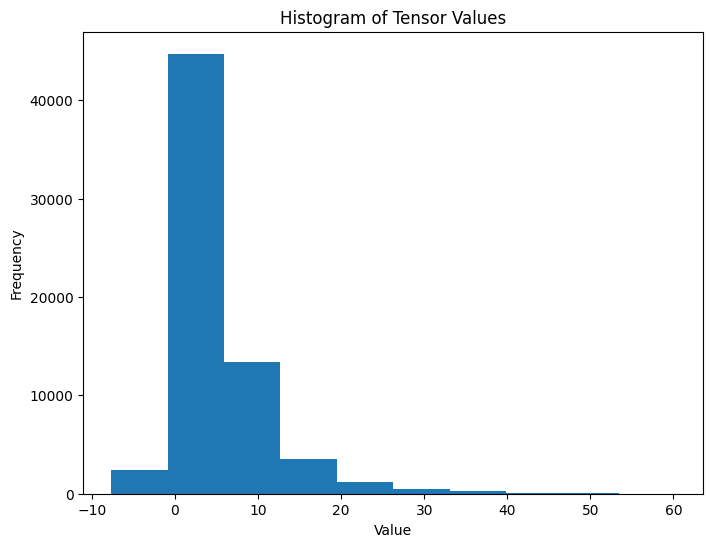

In [10]:
draw_histogram(test_y)

## Model Definitions

In [11]:
from model import ExpectedYardsModel

## Training Pipeline

### Create dataloaders to support batched training

In [12]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [13]:
def accuracy_within_one(y_pred, y_true):
    # Calculate the absolute difference
    diff = torch.abs(y_pred - y_true)

    # Count how many predictions are within ±1
    correct = torch.sum(diff <= 1.0)
    # Calculate the accuracy
    accuracy = correct.item() / len(y_pred)
    return accuracy

### Training loop

In [14]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 6
model = ExpectedYardsModel()

layer_gradients = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
criterion = nn.L1Loss()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    #Valudation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for cur_val_x, cur_val_y in val_loader:
            val_outputs = model(cur_val_x)
            val_acc += accuracy_within_one(val_outputs, cur_val_y)
            val_loss += criterion(val_outputs, cur_val_y).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

In [12]:
torch.save(model.state_dict(), './expected_yards_model.pt')